<a href="https://colab.research.google.com/github/sukritimahajan35/Semantic-Text-Similarity-SBERT/blob/main/Sentence_BERT_all_distilroberta_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Required libraries

In [3]:
!pip install papermill
!pip install datasets sentence-transformers
!pip install xgboost
!pip install scikit-learn
!pip install matplotlib seaborn

  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-non

Load SNLI Dataset

In [5]:
from datasets import load_dataset

# Load SNLI dataset
snli = load_dataset('snli')

# Check dataset structure
print(snli)

# Extract premises, hypotheses, and labels
train_data = snli['train']
premises = train_data['premise']
hypotheses = train_data['hypothesis']
labels = train_data['label']  # 0: entailment, 1: neutral, 2: contradiction

# Remove rows with None or missing data
filtered_data = [(p, h, l) for p, h, l in zip(premises, hypotheses, labels) if p and h]
premises, hypotheses, labels = zip(*filtered_data)

print(f"Loaded {len(premises)} sentence pairs.")

validation-00000-of-00001.parquet:   0%|          | 0.00/413k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
})
Loaded 550152 sentence pairs.


Preprocess and Balance Dataset

In [6]:
from sklearn.utils import resample
import random

# Convert to a list for upsampling
data = list(zip(premises, hypotheses, labels))

# Separate by class labels
entailment = [d for d in data if d[2] == 0]
neutral = [d for d in data if d[2] == 1]
contradiction = [d for d in data if d[2] == 2]

# Upsample the minority classes (optional)
max_size = max(len(entailment), len(neutral), len(contradiction))

entailment_upsampled = resample(entailment, replace=True, n_samples=max_size, random_state=42)
neutral_upsampled = resample(neutral, replace=True, n_samples=max_size, random_state=42)
contradiction_upsampled = resample(contradiction, replace=True, n_samples=max_size, random_state=42)

# Combine the classes back together
balanced_data = entailment_upsampled + neutral_upsampled + contradiction_upsampled

# Shuffle the dataset
random.shuffle(balanced_data)

# Unzip back to premises, hypotheses, and labels
premises, hypotheses, labels = zip(*balanced_data)

print(f"Loaded {len(premises)} balanced sentence pairs.")

Loaded 550248 balanced sentence pairs.


Sentence Embeddings with Sentence-BERT - all-distilroberta-v1

In [7]:
from sentence_transformers import SentenceTransformer

# Load Sentence-BERT model
model = SentenceTransformer('all-distilroberta-v1')

# Generate embeddings for both premises and hypotheses
premise_embeddings = model.encode(premises, show_progress_bar=True)
hypothesis_embeddings = model.encode(hypotheses, show_progress_bar=True)

print(f"Premise Embedding Shape: {premise_embeddings.shape}")
print(f"Hypothesis Embedding Shape: {hypothesis_embeddings.shape}")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/17196 [00:00<?, ?it/s]

Batches:   0%|          | 0/17196 [00:00<?, ?it/s]

Premise Embedding Shape: (550248, 768)
Hypothesis Embedding Shape: (550248, 768)


Similarity Analysis (Cosine Similarity)

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

# Example: Find similarity between the first premise and all hypotheses
similarity_scores = cosine_similarity([premise_embeddings[0]], hypothesis_embeddings)

# Retrieve top-5 most similar hypotheses
top_indices = similarity_scores[0].argsort()[-5:][::-1]
print("Top 5 Similar Hypotheses:")
for idx in top_indices:
    print(f"Score: {similarity_scores[0][idx]:.2f}, Hypothesis: {hypotheses[idx]}")

Top 5 Similar Hypotheses:
Score: 0.79, Hypothesis: A woman in a red dress walks down the street.
Score: 0.79, Hypothesis: A woman in a red dress walks down the street.
Score: 0.79, Hypothesis: A woman in a red dress walks down the street.
Score: 0.76, Hypothesis: A woman in a red dress.
Score: 0.76, Hypothesis:  An attractive woman in red boots is walking.


Semantic Analysis - Sentiment or Similarity Analysis

In [9]:
# Example: Perform semantic similarity analysis between two sentences
sentence_1 = "A person is walking in the park."
sentence_2 = "Someone is strolling in a garden."

# Get embeddings
embedding_1 = model.encode(sentence_1)
embedding_2 = model.encode(sentence_2)

# Compute cosine similarity
similarity = cosine_similarity([embedding_1], [embedding_2])
print(f"Semantic similarity score between the two sentences: {similarity[0][0]:.2f}")

Semantic similarity score between the two sentences: 0.57


Question-Answer Pair Generation (Using Premise and Hypothesis)

In [10]:
import numpy as np

def generate_question_answer_with_model(premise, hypothesis):
    # Generate embeddings for premise and hypothesis
    premise_embedding = model.encode(premise)
    hypothesis_embedding = model.encode(hypothesis)

    # Compare similarity between premise and hypothesis
    similarity_score = np.dot(premise_embedding, hypothesis_embedding) / (np.linalg.norm(premise_embedding) * np.linalg.norm(hypothesis_embedding))

    # Generate a question based on the premise using the model
    question = f"What is happening in the following sentence: '{premise}'?"

    # Determine the answer based on similarity score or other logic
    if similarity_score > 0.7:  # High similarity (entailment)
        answer = "Yes, the statement is likely true."
    else:  # Low similarity (contradiction or neutral)
        answer = "No, the statement doesn't match the premise."

    return question, answer

# Generate Q&A for the first example
question, answer = generate_question_answer_with_model(premises[0], hypotheses[0])
print(f"Generated Question: {question}")
print(f"Generated Answer: {answer}")

Generated Question: What is happening in the following sentence: 'A woman walking while wearing a red dress and red shoes.'?
Generated Answer: No, the statement doesn't match the premise.


Model Evaluation with XGBoost (Classification)

In [11]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# import numpy as np

# # Combine embeddings (premise and hypothesis embeddings)
# combined_embeddings = [np.concatenate((p, h)) for p, h in zip(premise_embeddings, hypothesis_embeddings)]

# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(combined_embeddings, labels, test_size=0.2, random_state=42)

# # Train an XGBoost classifier
# xgb_clf = XGBClassifier(eval_metric='mlogloss')
# xgb_clf.fit(X_train, y_train)

# # Evaluate the model
# y_pred = xgb_clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"XGBoost Model Accuracy: {accuracy:.2f}")

Clustering: KMeans Clustering with PCA Visualization

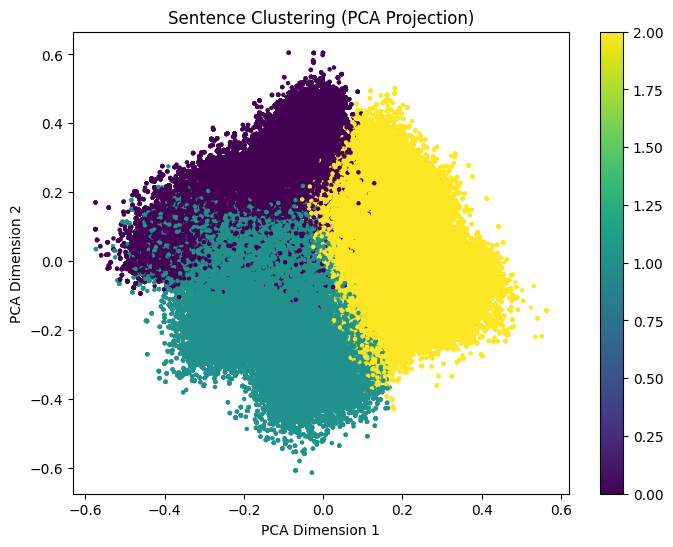

In [12]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(premise_embeddings)

# Visualize clusters using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(premise_embeddings)

# Plotting the clusters with PCA reduction
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', s=5)
plt.title("Sentence Clustering (PCA Projection)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.colorbar()
plt.show()

Query-Based Information Retrieval (With Semantic Matching)

In [13]:
# Get query input from the user
query = input("Enter your query sentence: ")  # Prompting for input

# Generate the query embedding
query_embedding = model.encode(query)

# Compute similarity scores between the query and all premises
similarity_scores = cosine_similarity([query_embedding], premise_embeddings)

# Ensure the premise and similarity scores align
assert len(premises) == len(similarity_scores[0]), "Premises length and similarity scores length mismatch!"

# Retrieve top N most similar sentences with diversity
top_n = 5
retrieved_indices = set()
top_results = []

for idx in similarity_scores[0].argsort()[::-1]:
    if idx < len(premises) and premises[idx] not in retrieved_indices:
        top_results.append((similarity_scores[0][idx], premises[idx]))
        retrieved_indices.add(premises[idx])
    if len(top_results) >= top_n:
        break

# Display top matches
print("\nTop Matches for Query (Diverse Results):")
for score, sentence in top_results:
    print(f"Score: {score:.2f}, Sentence: {sentence}")

Enter your query sentence: Will you have a cup of coffee?

Top Matches for Query (Diverse Results):
Score: 0.78, Sentence: Are you coming with me for a cup of coffee?
Score: 0.46, Sentence: A bald with man with a blue shirt and is holding a cup of coffee in his hand.
Score: 0.45, Sentence: Man with cupcakes and coffee contemplating the statement "who are you?"
Score: 0.45, Sentence: A construction worker looking at his cup of coffee.
Score: 0.44, Sentence: Two men are having coffee,.


In [14]:
# Get query input from the user
query = input("Enter your query sentence: ")  # Prompting for input

# Generate the query embedding
query_embedding = model.encode(query)

# Compute similarity scores between the query and all premises
similarity_scores = cosine_similarity([query_embedding], premise_embeddings)

# Ensure the premise and similarity scores align
assert len(premises) == len(similarity_scores[0]), "Premises length and similarity scores length mismatch!"

# Retrieve top N most similar sentences with diversity
top_n = 5
retrieved_indices = set()
top_results = []

for idx in similarity_scores[0].argsort()[::-1]:
    if idx < len(premises) and premises[idx] not in retrieved_indices:
        top_results.append((similarity_scores[0][idx], premises[idx]))
        retrieved_indices.add(premises[idx])
    if len(top_results) >= top_n:
        break

# Display top matches
print("\nTop Matches for Query (Diverse Results):")
for score, sentence in top_results:
    print(f"Score: {score:.2f}, Sentence: {sentence}")

Enter your query sentence: I am watching a movie

Top Matches for Query (Diverse Results):
Score: 0.58, Sentence: The marquee of movies now playing.
Score: 0.52, Sentence: a line waiting to get into a movie
Score: 0.47, Sentence: People watching an interesting thing.
Score: 0.47, Sentence: Young children sitting and watching a projector film.
Score: 0.45, Sentence: A lady bowling while watching a movie.


In [15]:
# Get query input from the user
query = input("Enter your query sentence: ")  # Prompting for input

# Generate the query embedding
query_embedding = model.encode(query)

# Compute similarity scores between the query and all premises
similarity_scores = cosine_similarity([query_embedding], premise_embeddings)

# Ensure the premise and similarity scores align
assert len(premises) == len(similarity_scores[0]), "Premises length and similarity scores length mismatch!"

# Retrieve top N most similar sentences with diversity
top_n = 5
retrieved_indices = set()
top_results = []

for idx in similarity_scores[0].argsort()[::-1]:
    if idx < len(premises) and premises[idx] not in retrieved_indices:
        top_results.append((similarity_scores[0][idx], premises[idx]))
        retrieved_indices.add(premises[idx])
    if len(top_results) >= top_n:
        break

# Display top matches
print("\nTop Matches for Query (Diverse Results):")
for score, sentence in top_results:
    print(f"Score: {score:.2f}, Sentence: {sentence}")

Enter your query sentence: Today is a sunny day.

Top Matches for Query (Diverse Results):
Score: 0.83, Sentence: People outside on a sunny day.
Score: 0.77, Sentence: People pass time outside on a sunny day.
Score: 0.77, Sentence: People outside walking and enjoying a sunny day.
Score: 0.77, Sentence: A normal sunny day in a big city.
Score: 0.76, Sentence: Group of people on a sunny day.


In [16]:
# Print some premises to verify
print(f"First 5 premises:\n {premises[:5]}")

# Ensure you are encoding the correct data
premise_embeddings = model.encode(premises, show_progress_bar=True)
query_embedding = model.encode(query)  # Encoding only the query

# Verify lengths after encoding
print(f"Length of encoded premises: {len(premise_embeddings)}")
print(f"Length of similarity scores: {len(similarity_scores[0])}")

First 5 premises:
 ('A woman walking while wearing a red dress and red shoes.', 'A bongo player wearing a red shirt playing in a band.', 'A beach scene with three boys in swim shorts each holding paddle ball racquets but no ball in sight.', 'A lesbian couple kiss while walking down a busy street.', 'A white dog is swimming after a duck.')


Batches:   0%|          | 0/17196 [00:00<?, ?it/s]

Length of encoded premises: 550248
Length of similarity scores: 550248


In [17]:
# Assuming you have already defined the similarity scores after encoding
similarity_scores = cosine_similarity([query_embedding], premise_embeddings)

# Verify lengths
print(f"Length of premises: {len(premises)}")
print(f"Length of similarity_scores: {len(similarity_scores[0])}")

Length of premises: 550248
Length of similarity_scores: 550248


Calculating the Difference in Embeddings Between Premise and Hypothesis

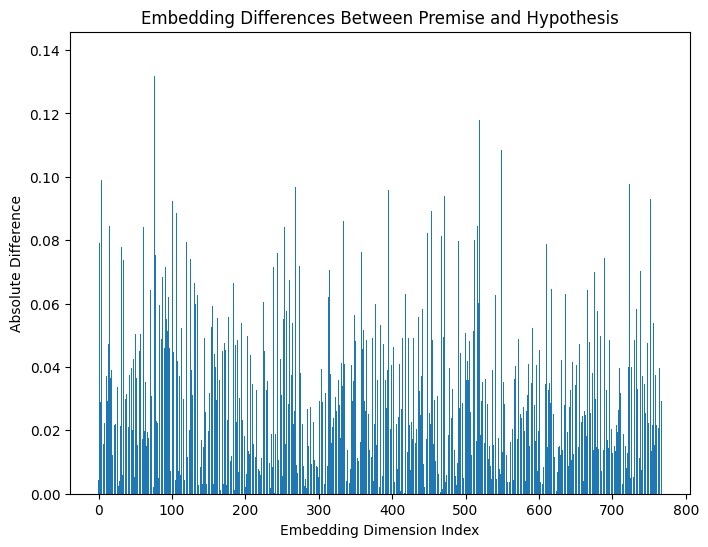

Embedding Difference Example (Premise-Hypothesis):
[4.47923411e-03 7.92573094e-02 6.23318627e-02 2.89554894e-02
 9.89392623e-02 2.71646474e-02 1.38312709e-02 1.56361684e-02
 2.21977234e-02 6.14504963e-02 3.51335667e-02 3.71733382e-02
 2.94146240e-02 1.53172314e-02 4.71050143e-02 8.44321549e-02
 3.64947356e-02 5.81362098e-02 3.89707014e-02 1.23082083e-02
 5.28811337e-03 3.78141552e-02 2.15941779e-02 2.20947079e-02
 4.25984636e-02 2.97378674e-02 3.38208340e-02 2.36999616e-03
 1.52315646e-02 3.89537588e-03 2.14386713e-02 7.78788328e-02
 2.62024086e-02 5.95158711e-03 7.36689270e-02 2.07927451e-02
 1.91376824e-02 2.99201775e-02 3.14546749e-02 2.93071941e-03
 1.59057826e-02 2.09699422e-02 3.76074649e-02 1.89417712e-02
 4.01874445e-03 3.97167839e-02 1.99954938e-02 2.29158029e-02
 4.25413102e-02 5.31282742e-03 5.03878556e-02 2.91741677e-02
 3.65648940e-02 1.52999535e-02 3.66070457e-02 4.06429470e-02
 4.50585559e-02 5.04453890e-02 9.22922045e-03 1.01979673e-02
 1.71352867e-02 8.42129588e-02 4.5

In [18]:
import numpy as np

# Example: Calculate the difference in embeddings between premise and hypothesis
embedding_diff = np.abs(premise_embeddings[0] - hypothesis_embeddings[0])

# Visualize the embedding differences for the first sentence pair
plt.figure(figsize=(8, 6))
plt.bar(range(len(embedding_diff)), embedding_diff)
plt.title("Embedding Differences Between Premise and Hypothesis")
plt.xlabel("Embedding Dimension Index")
plt.ylabel("Absolute Difference")
plt.show()

print("Embedding Difference Example (Premise-Hypothesis):")
print(embedding_diff)

Visualizing Sentence Embedding Distributions

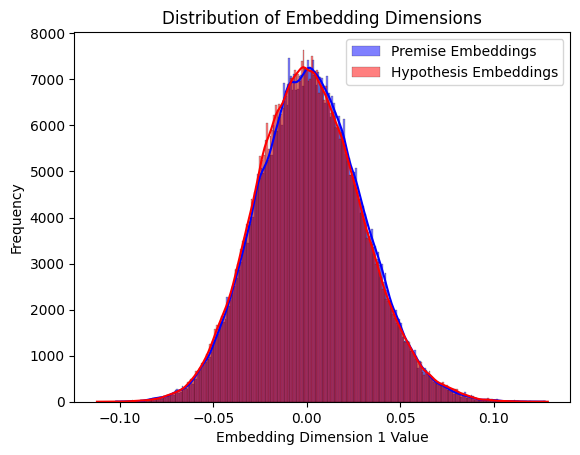

In [19]:
import seaborn as sns

# Visualize the distribution of the first dimension of premise embeddings
sns.histplot(premise_embeddings[:, 0], kde=True, color='blue', label='Premise Embeddings')
sns.histplot(hypothesis_embeddings[:, 0], kde=True, color='red', label='Hypothesis Embeddings')
plt.legend()
plt.title("Distribution of Embedding Dimensions")
plt.xlabel("Embedding Dimension 1 Value")
plt.ylabel("Frequency")
plt.show()